In [1]:
import itertools
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
max_bidders = 10
sample_size = 1e4

samples   = np.random.uniform( size = ( int( sample_size ), max_bidders ) )
sample_df = pd.concat( [ pd.DataFrame.from_dict( { 'v': samples[:,i] } ).assign( a = range( int( sample_size ) ), i = i ) for i in range( max_bidders ) ], axis = 0 )

In [6]:
def BNEevaldf ( sample_df, n ):
    return sample_df \
        .query( f'i < {n}' ) \
        .assign( rank = lambda _df: _df[['a','v']].groupby( 'a' ).rank( ascending = False ) ) \
        .query( 'rank <= 2' )



def BNEeval ( sample_df, n ):
    sample_df = BNEevaldf( sample_df, n )
    return {
        'revenue': np.mean( sample_df.query( 'rank == 2' ).v ),
        'surplus': np.mean( sample_df.query( 'rank == 1' ).v )
    }



def MMLevaldf ( sample_df, n, M ):
    scales = pd.DataFrame( 1 - np.power( M / ( M + 1 ), M - np.arange( 0, M ) ), columns = [ 's' ] )
    return sample_df \
        .query( f'i < {n}' ) \
        .merge( scales, how = 'cross' ) \
        .assign( b    = lambda _df: _df.v * _df.s ) \
        .assign( rank = lambda _df: _df[['a','b']].groupby( 'a' ).rank( ascending = False ) )



def MMLeval ( sample_df, n, M ):
    sample_df = MMLevaldf( sample_df, n, M ).query( f'rank <= {M}' ).groupby( 'a' ).sum()
    return {
        'revenue': np.mean( sample_df.b / M ),
        'surplus': np.mean( sample_df.v / M )
    }



alphas = np.arange( start = 0.1, stop = 3.0, step = 0.1 )
ns     = np.arange( start = 2, stop = 5 )
Ms     = np.arange( start = 2, stop = 10 )

results = pd.DataFrame()
for ( alpha, n, M ) in tqdm( itertools.product( alphas, ns, Ms ), total = len( alphas ) * len( ns ) * len( Ms ) ):
    sample_df_scaled = sample_df.assign( v = lambda _df: ( 1 - np.power( 1 - _df.v, 1 / alpha ) ) * 100 )

    bne = BNEeval( sample_df_scaled, n )
    mml = MMLeval( sample_df_scaled, n, M )

    results = pd.concat( [
        results,
        pd.DataFrame.from_records( [ {
            'alpha':       alpha,
            'n':           n,
            'M':           M,
            'revenue_bne': bne['revenue'],
            'revenue_mml': mml['revenue'],
            'surplus_bne': bne['surplus'],
            'surplus_mml': mml['surplus']
        } ] )
    ], axis = 0 )

100%|██████████| 696/696 [00:39<00:00, 17.84it/s]


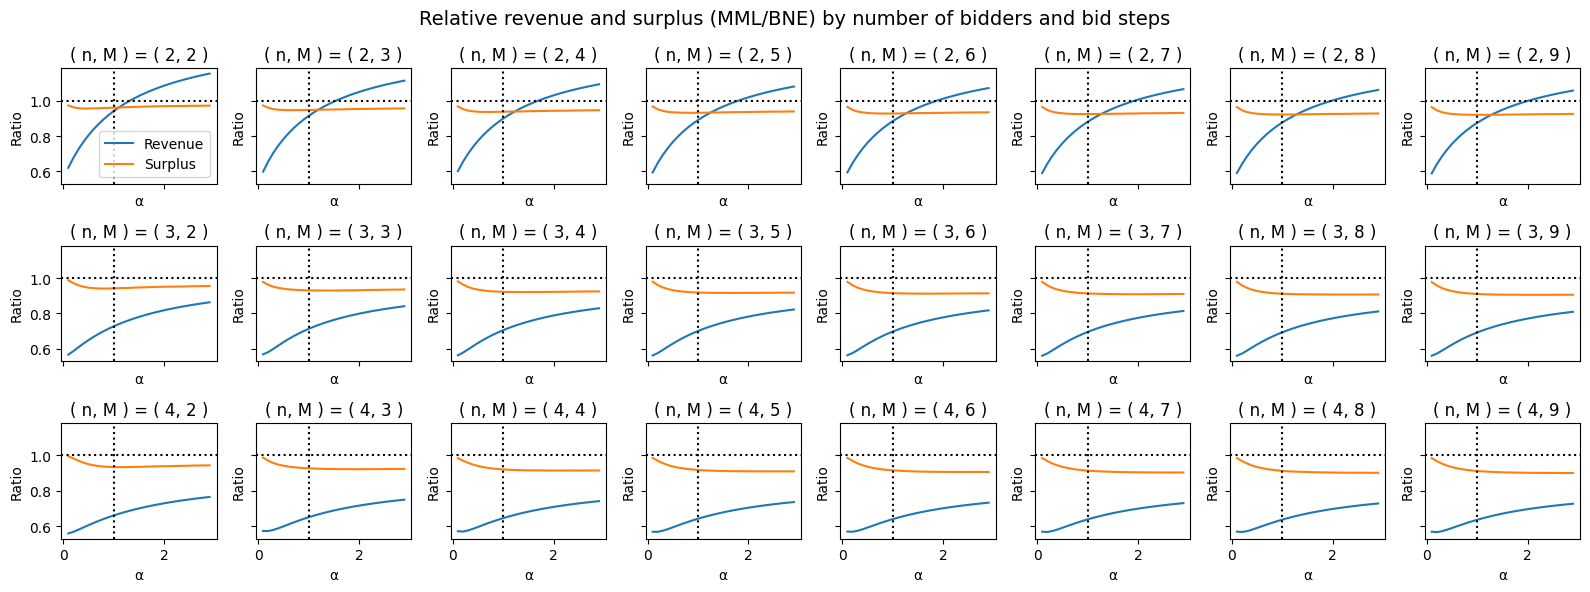

In [20]:
figure, axes = plot.subplots( len( ns ), len( Ms ), sharex = True, sharey = True )
figure.set_size_inches( 2 * len( Ms ), 2 * len( ns ) )

for ( i_n, i_M ) in itertools.product( range( len( ns ) ), range( len( Ms ) ) ):
    n = ns[i_n]
    M = Ms[i_M]

    _axes    = axes[i_n,i_M]
    _results = results.query( f'n == {n} and M == {M}' ).sort_values( 'alpha' )

    _axes.plot( _results.alpha, _results.revenue_mml / _results.revenue_bne, label = 'Revenue' )
    _axes.plot( _results.alpha, _results.surplus_mml / _results.surplus_bne, label = 'Surplus' )
    _axes.set_xlabel( 'α' )
    _axes.set_ylabel( 'Ratio' )
    _axes.axhline( 1.0, color = 'black', linestyle = 'dotted' )
    _axes.axvline( 1.0, color = 'black', linestyle = 'dotted' )
    _axes.set_title( f'( n, M ) = ( {n}, {M} )' )

axes[0,0].legend( loc = 'best' )
plot.suptitle( 'Relative revenue and surplus (MML/BNE) by number of bidders and bid steps', size = 14 )
plot.tight_layout()
plot.show()

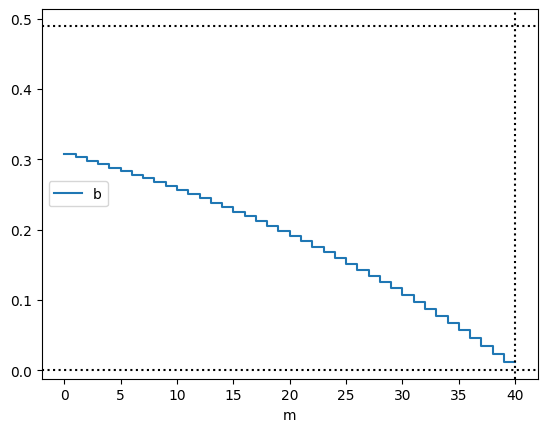

In [254]:
df  = MMLevaldf( sample_df, 2, 40 )
df  = df.query( 'a == 0 and i == 0' ).reset_index().assign( m = lambda _df: _df.index )[['v','m','b']]
v   = np.mean( df.v )
_df = pd.concat( [ df.drop( 'v', axis = 1 ), df.drop( 'v', axis = 1 ).assign( m = lambda _df: _df.m + 1 ) ] ).sort_values( [ 'm', 'b' ], ascending = [ True, False ] )

_df.plot( x = 'm', y = 'b' )
plot.axhline( v, color = 'black', linestyle = 'dotted' )
plot.axvline( len( df ), color = 'black', linestyle = 'dotted' )
plot.axhline( 0, color = 'black', linestyle = 'dotted' )
plot.show()